In [1]:
!pip install statsmodels
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import zipfile
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

import helper_functions as hlp
import function_model_definition as md
import function_read_data as rdat

print("TF  Version",tf.__version__)

TF  Version 2.4.0


#### Helpfull Links

for best Threshold:
https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

for gradcam averaging:
https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

## Load Data and Results

In [3]:
# should csv be saved?
save_file = False

In [4]:
# ## 10 Fold
# # Define the path + output path:
# print(os.getcwd())
# DIR = "/tf/notebooks/"
# DATA_DIR = "/tf/notebooks/brdd/xAI_3d/data/"
# WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/10Fold/"
# OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/data/" #Also change name of output file!!!

# # load data
# id_tab = pd.read_csv(DATA_DIR + "10Fold_ids.csv", sep=",")
# X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")

# # define save name
# all_result_name = "all_tab_results_10Fold"

# # define splits
# which_splits = list(range(0,10)) # 10 Fold

# print(id_tab.shape)
# print(X.shape)


In [5]:
## Andrea 6 Split

# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/data/"  #Also change name of output file!!!
WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/andrea_split/"

# define data paths
img_path = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
tab_path = IMG_DIR + 'baseline_data_zurich_prepared.csv'
split_path = '/tf/notebooks/brdd/xAI_3d/data/andrea_splits.csv'

# define save name
all_result_name = "all_tab_results_andrea_split"

# # define splits
which_splits = list(range(1,7)) # Andrea

/tf/notebooks/brdd/xAI_3d


In [6]:
## define model numbers
model_nrs = list(range(10, 15))

# define model
layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

input_dim = (128, 128, 28, 1)
output_dim = 1
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True
        

In [7]:
results_list = [] # test dataset results
valid_list = [] # validation datset results

# loop over splits and models
start = time.time()
for which_split in which_splits:
    if check_print:
        print(" ")
        print("---- Start Reading Data of Split " + str(which_split) + " ----")
        print(" ")
    
#     # 10 Fold
#     (X_train, X_valid, X_test), (y_train, y_valid, y_test) = rdat.split_data(id_tab, X, which_split)
#     results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()
    
    # Andrea
    (X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data_andrea(
        path_img = img_path, 
        path_tab = tab_path, 
        path_splits = split_path, 
        split = which_split, 
        check_print = check_print)
    
    # add variable with current split
    results["test_split"] = which_split        
    
    # create new df for validation set, to calculate classification threshold 
    # => not cheating when calc on valid
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
    
    if check_print:
        print(" ")
        print("---- Starting Result Calculation of Split " + str(which_split) + " ----")
        print(" ")
        
    y_test_preds = []
    y_valid_preds = []
     
    for model_nr in model_nrs:
        if check_print:
            print("Now calculating model nr. " + str(model_nr))
        
        model_3d.load_weights(WEIGHT_DIR +
            "3d_cnn_binary_model_split" + str(which_split) + 
            "_unnormalized_avg_layer_paper_model_sigmoid_activation_" + str(model_nr) + ".h5")
        
        y_test_preds.append(model_3d.predict(X_test).squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]
        
        y_valid_preds.append(model_3d.predict(X_valid).squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]
    
    y_test_preds = np.array(y_test_preds)
    results["y_pred_linear_avg"] = np.mean(y_test_preds, axis = 0)
    results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_test_preds), axis = 0))
    
    y_valid_preds = np.array(y_valid_preds)
    validation_results["y_pred_linear_avg"] = np.mean(y_valid_preds, axis = 0)
    validation_results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_valid_preds), axis = 0))
        
    results_list.append(results)
    valid_list.append(validation_results)
        
if check_print:
    end = time.time()
    print(" ")
    print("---- DONE ----")
    print(" ")   
    print("Duration of Execution: " + str(end-start))               
        

 
---- Start Reading Data of Split 1 ----
 
image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)
split file shape in:  (407, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
End shapes X (train, val, test):  (325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
End shapes y (train, val, test):  (325,) (41,) (41,)
 
---- Starting Result Calculation of Split 1 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 2 ----
 
image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)
split file shape in:  (407, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
End shapes X (train, val, test):  (325, 128, 128, 28) (41, 128, 128, 28) (4

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [8]:
# should threshold be calculated per split or over all?

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.15868594
Accuracy to beat: 0.8292682926829268
Accuracy: 0.8536585365853658
Spezifität:  0.8235294117647058
Sensitivität:  1.0


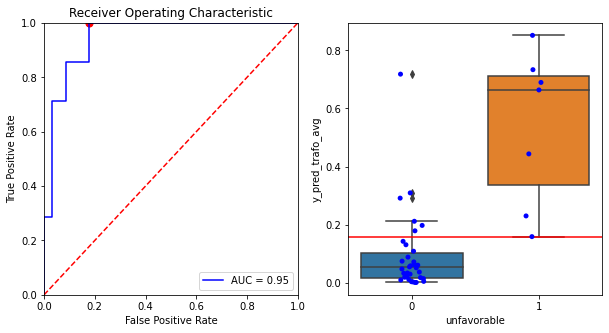

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.29512113
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8292682926829268
Spezifität:  0.8484848484848485
Sensitivität:  0.75


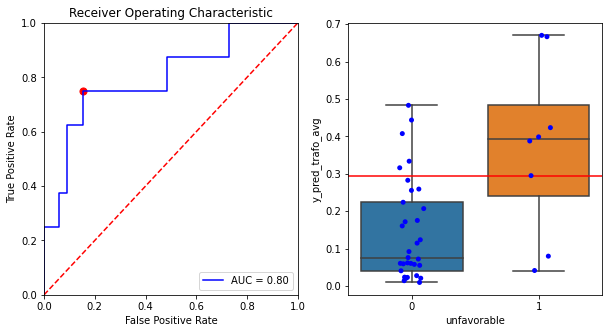

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.058929767
Accuracy to beat: 0.8780487804878049
Accuracy: 0.8048780487804879
Spezifität:  0.7777777777777778
Sensitivität:  1.0


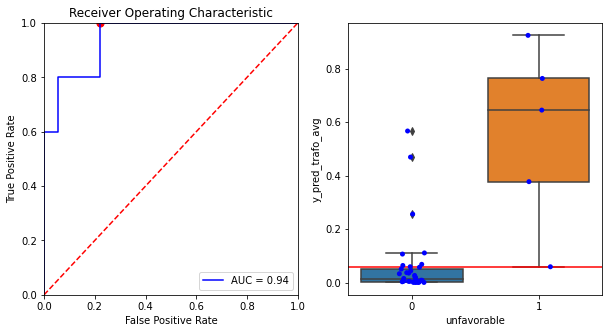

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.21555537
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7804878048780488
Spezifität:  0.8235294117647058
Sensitivität:  0.5714285714285714


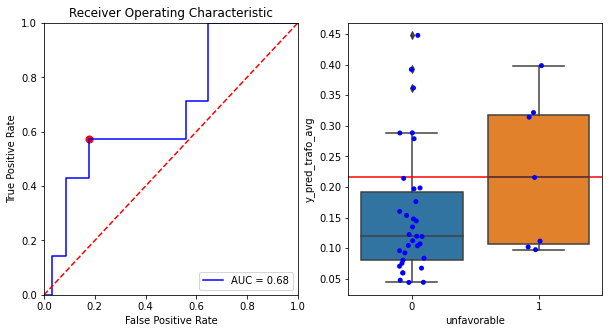

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.11669684
Accuracy to beat: 0.9024390243902439
Accuracy: 0.7804878048780488
Spezifität:  0.7837837837837838
Sensitivität:  0.75


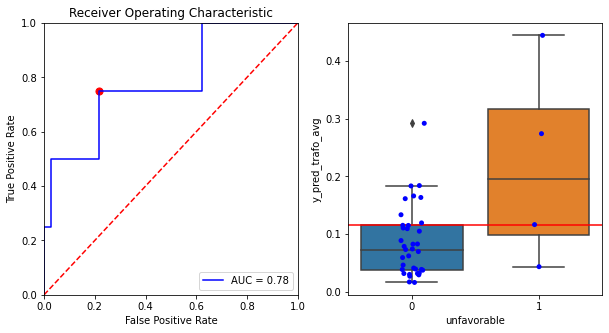

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.2142768
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7560975609756098
Spezifität:  0.7647058823529411
Sensitivität:  0.7142857142857143


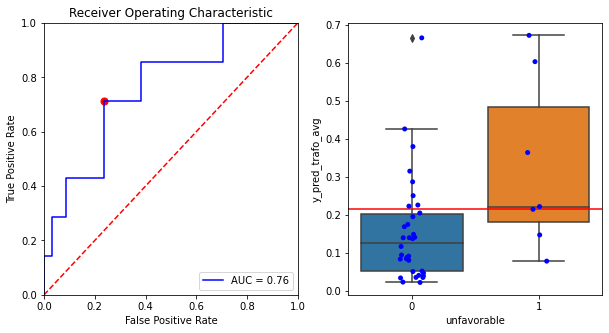

In [9]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [10]:
valid_thresholds

[0.15868594, 0.29512113, 0.058929767, 0.21555537, 0.11669684, 0.2142768]

### Apply Threshold to Testdata

 
---- Split 1 ----
 
Accuracy to beat: 0.9024390243902439
Accuracy: 0.8048780487804879
Spezifität:  0.8108108108108107
Sensitivität:  0.75


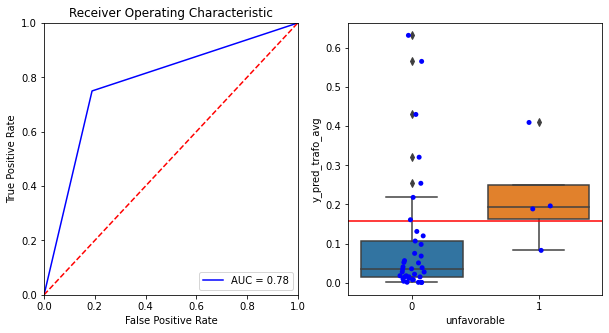

 
---- Split 2 ----
 
Accuracy to beat: 0.8780487804878049
Accuracy: 0.8292682926829268
Spezifität:  0.8333333333333334
Sensitivität:  0.8


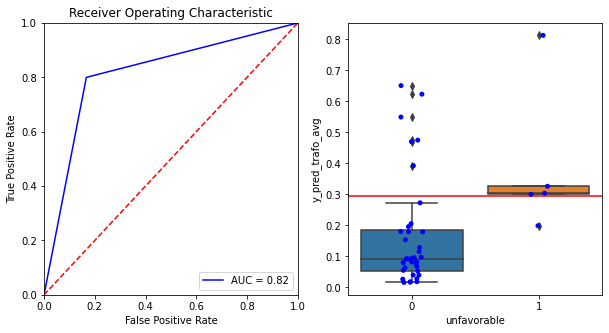

 
---- Split 3 ----
 
Accuracy to beat: 0.7804878048780488
Accuracy: 0.8048780487804879
Spezifität:  0.875
Sensitivität:  0.5555555555555556


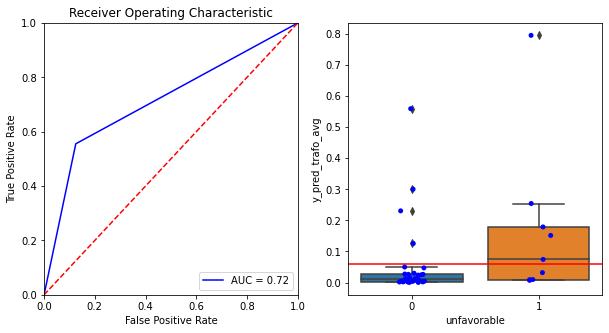

 
---- Split 4 ----
 
Accuracy to beat: 0.7317073170731707
Accuracy: 0.7317073170731707
Spezifität:  0.8666666666666667
Sensitivität:  0.36363636363636365


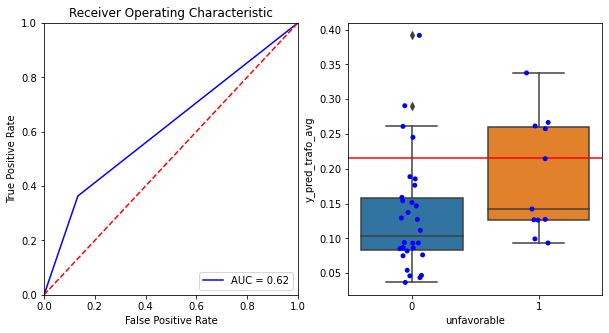

 
---- Split 5 ----
 
Accuracy to beat: 0.926829268292683
Accuracy: 0.7317073170731707
Spezifität:  0.736842105263158
Sensitivität:  0.6666666666666666


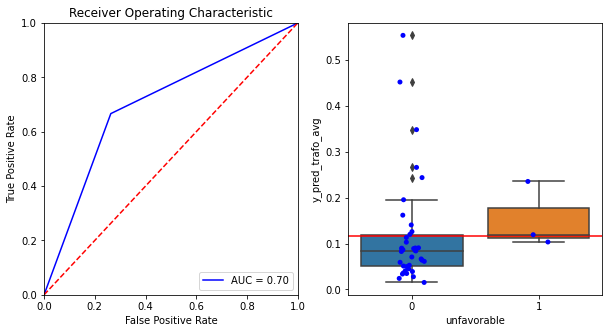

 
---- Split 6 ----
 
Accuracy to beat: 0.8536585365853658
Accuracy: 0.7560975609756098
Spezifität:  0.8285714285714285
Sensitivität:  0.3333333333333333


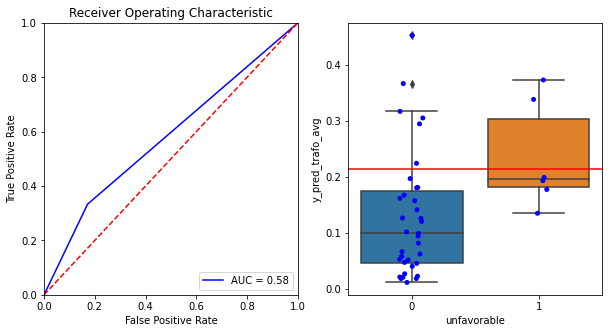

In [11]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [12]:
all_results = pd.concat(results_list)
all_results.shape

(246, 14)

Accuracy to beat: 0.8455284552845528
Accuracy: 0.7764227642276422
Spezifität:  0.8221153846153846
Sensitivität:  0.5263157894736842


<AxesSubplot:xlabel='unfavorable', ylabel='y_pred_trafo_avg'>

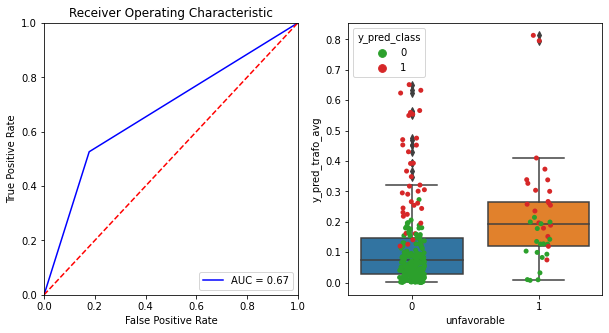

In [13]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    ax = ax2)
    

## Calculation of one threshold

threshold:  0.2142768
Accuracy to beat: 0.8455284552845528
Accuracy: 0.8333333333333334
Spezifität:  0.8557692307692308
Sensitivität:  0.7105263157894737


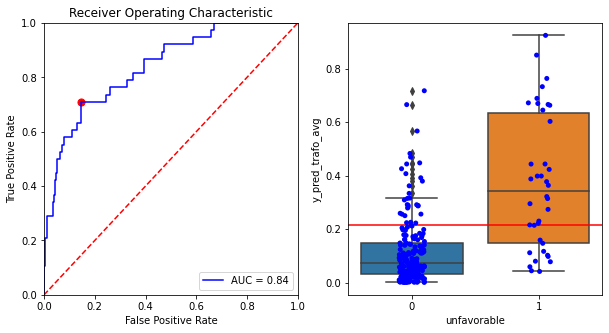

In [14]:
all_valid_results = pd.concat(valid_list)

y_org = all_valid_results["unfavorable"]
y_pred = all_valid_results["y_pred_trafo_avg"]

fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate geometric mean of tpr and fpr to find best threshold
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
valid_threshold = threshold[index]
print("threshold: ", threshold[index])


y_pred_label = (y_pred >= threshold[index]).squeeze()
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[index])
print("Sensitivität: ", tpr[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_valid_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    color = 'blue',
    data = all_valid_results,
    ax = ax2)
ax2.axhline(y = threshold[index], color = "red")

Accuracy to beat:     0.8455
Accuracy:             0.7805
----------------------------
AUC of probabilities: 0.7382
NLL :                 0.4095
Threshold:            0.2143
Spezifität:           0.851
Sensitivität:         0.3947


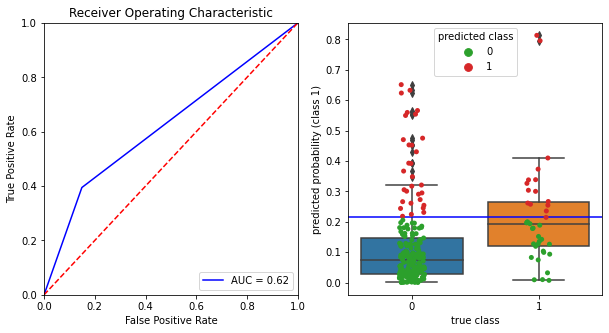

In [15]:
all_results["threshold2"] = valid_threshold
all_results["y_pred_class2"] = (all_results["y_pred_trafo_avg"] >= all_results["threshold2"]).astype(int)

y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class2"]
y_pred_prob = all_results["y_pred_trafo_avg"]

# calculate fpr and tpr for probabilities
fpr_prob, tpr_prob, thresholds_prob = metrics.roc_curve(y_org, y_pred_prob)

# calculate fpr, tpr and thresholds for class
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
print("Accuracy to beat:     " + str(round(1 - np.mean(y_org), 4)))
print("Accuracy:             " + str(round(np.mean(y_pred == y_org), 4)))
print("----------------------------")

print("AUC of probabilities: " + str(round(metrics.auc(fpr_prob, tpr_prob), 4)))
print("NLL :                 " + str(round(metrics.log_loss(y_org, y_pred_prob), 4)))

print("Threshold:            " + str(round(valid_threshold, 4)))

print("Spezifität:           " + str(round(1-fpr[1], 4)))
print("Sensitivität:         " + str(round(tpr[1], 4)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class2',
    palette=["C2", "C3"],
    data = all_results,
    ax = ax2)
plt.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='predicted probability (class 1)')
ax2.axhline(y = valid_threshold, color = "blue")

In [16]:
all_results

,p_idx,p_id,mrs,unfavorable,test_split,y_pred_model_10,y_pred_model_11,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,threshold2,y_pred_class2
0,181,239.0,2.0,0,1,0.001944,0.007217,0.003051,0.002333,0.005528,0.004015,0.003537,0.158686,0,0.214277,0
1,3,3.0,0.0,0,1,0.066776,0.176739,0.357961,0.421386,0.212879,0.247148,0.218066,0.158686,1,0.214277,1
2,371,515.0,2.0,0,1,0.004576,0.018158,0.010685,0.002880,0.010099,0.009280,0.007641,0.158686,0,0.214277,0
3,49,63.0,0.0,0,1,0.084306,0.122671,0.148182,0.167622,0.364284,0.177413,0.160814,0.158686,1,0.214277,0
4,159,215.0,2.0,0,1,0.014850,0.046055,0.006771,0.007944,0.042364,0.023597,0.017432,0.158686,0,0.214277,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,108,152.0,0.0,0,6,0.207283,0.180335,0.132504,0.141858,0.156599,0.163716,0.161971,0.214277,0,0.214277,0
37,216,299.0,4.0,1,6,0.303187,0.124954,0.085057,0.124674,0.101907,0.147956,0.135190,0.214277,0,0.214277,0
38,100,142.0,0.0,0,6,0.063465,0.063878,0.034832,0.059789,0.045044,0.053402,0.052079,0.214277,0,0.214277,0
39,382,526.0,0.0,0,6,0.025783,0.021141,0.014449,0.029901,0.009830,0.020221,0.018774,0.214277,0,0.214277,0


##### Save results

Delete threshold 1 because one threshold over everything is to be prefered.

In [17]:
all_results = all_results.drop(columns = ["y_pred_class", "threshold"])
all_results = all_results.rename(columns = {"y_pred_class2": "y_pred_class", "threshold2": "threshold"})

In [18]:
if save_file:
    all_results.to_csv(OUTPUT_DIR + all_results_name + ".csv",  index=False) # rename output file!!!!

### Check Splits

Only used for andreas/paper split

In [32]:
andrea_splits = pd.read_csv(split_path, 
                                sep='\,', header = None, engine = 'python', 
                                usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
andrea_splits.columns = andrea_splits.iloc[0]
andrea_splits.drop(index=0, inplace=True)
andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
print(andrea_splits[andrea_splits["type"].isin(["test"])].idx.nunique())
print(sum(andrea_splits["type"].isin(["test"])))

199
246


In [34]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup["p_id"].value_counts().value_counts()

2    39
3     4
Name: p_id, dtype: int64

In [36]:
print("Total duplicate: ", len(all_dup["p_id"].value_counts()))

print("gleich klassifieziert (%): ", np.mean(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))
print("gleich klassifieziert (abs): ", np.sum(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))

Total duplicate:  43
gleich klassifieziert (%):  0.9069767441860465
gleich klassifieziert (abs):  39


<AxesSubplot:xlabel='y_pred_trafo_avg', ylabel='Count'>

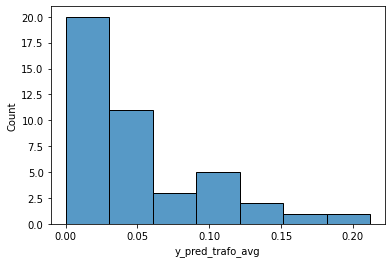

In [38]:
sns.histplot(all_dup.groupby("p_id").y_pred_trafo_avg.std())

In [37]:
all_dup

,p_idx,p_id,mrs,unfavorable,test_split,y_pred_model_10,y_pred_model_11,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class
35,7,9.0,0.0,0,4,0.020202,0.160466,0.090911,0.151571,0.145663,0.113762,0.093974,0.214277,0
17,7,9.0,0.0,0,5,0.115826,0.030605,0.013851,0.124906,0.015360,0.060109,0.040226,0.214277,0
13,17,24.0,2.0,0,5,0.153902,0.079607,0.053642,0.156859,0.169475,0.122697,0.113177,0.214277,0
26,17,24.0,2.0,0,1,0.012346,0.038021,0.006174,0.005716,0.040173,0.020486,0.014697,0.214277,0
31,33,43.0,0.0,0,1,0.127060,0.141026,0.302348,0.401410,0.397929,0.273955,0.254118,0.214277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,382,526.0,0.0,0,3,0.002441,0.000085,0.000079,0.000294,0.000242,0.000628,0.000259,0.214277,0
30,385,529.0,5.0,1,6,0.193829,0.138062,0.141202,0.178054,0.255392,0.181308,0.177649,0.214277,0
27,385,529.0,5.0,1,3,0.014360,0.022577,0.006393,0.003933,0.009908,0.011434,0.009600,0.214277,0
6,404,556.0,0.0,0,5,0.115579,0.007054,0.001242,0.132011,0.004788,0.052135,0.015092,0.214277,0


## Calibration Plot

In [24]:
cal_plot_datas = []
for split in which_splits:
    dat = all_results.loc[all_results["test_split"] == split]
    cal_plot_datas.append(hlp.cal_plot_data_prep(
        dat["y_pred_trafo_avg"].array, dat["unfavorable"].array
    ).select_dtypes(include=np.number))

In [25]:
all_cal_plot_datas = pd.concat(cal_plot_datas)
all_cal_plot_datas["iter"] = all_cal_plot_datas.index
all_cal_plot_datas = all_cal_plot_datas.groupby("iter")[
    ["predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper"]].mean()

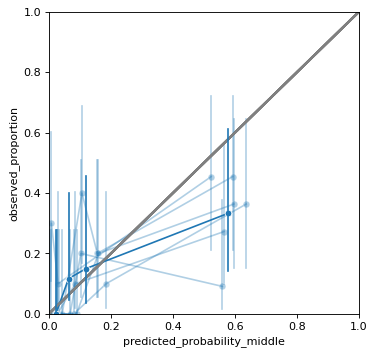

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

for i in range(len(which_splits)):
    hlp.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
hlp.cal_plot(all_cal_plot_datas, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

## Check Volume index

check if X_test and when selected via p_idx is same => for grad cams, because we have to get volume

In [27]:
with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

In [28]:
index = 0
results.p_id.array[0]

516.0

In [29]:
np.argwhere(pat == results.p_id.array[index]).squeeze()

array(394)

In [30]:
im1 = X_test[index].astype("float64")
im2 = X_in[np.argwhere(pat == results.p_id.array[index]).squeeze()].astype("float64")
np.allclose(im1, im2)

True

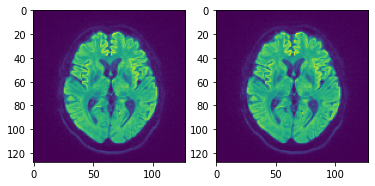

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1[:,:,14])
ax2.imshow(im2[:,:,14])